# Goal

Here, we will perform Milo differential abundance testing to examine how different antibody treatments influence frequencies of cell states.

# Import

In [1]:
import scanpy as sc
import pertpy as pt
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set scanpy settings
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (3,3)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42
mpl.rcParams['text.usetex']  = False

%load_ext autoreload
%autoreload 2

In [21]:
rna = sc.read_h5ad('/data1/rudenska/EYW/SIG19/scvi_outs/SIG19_DTR_CD4T_iLN_scvi.h5ad')

# Leiden Cluster Analysis

Here, we will examine different marker genes in the leiden clusters.

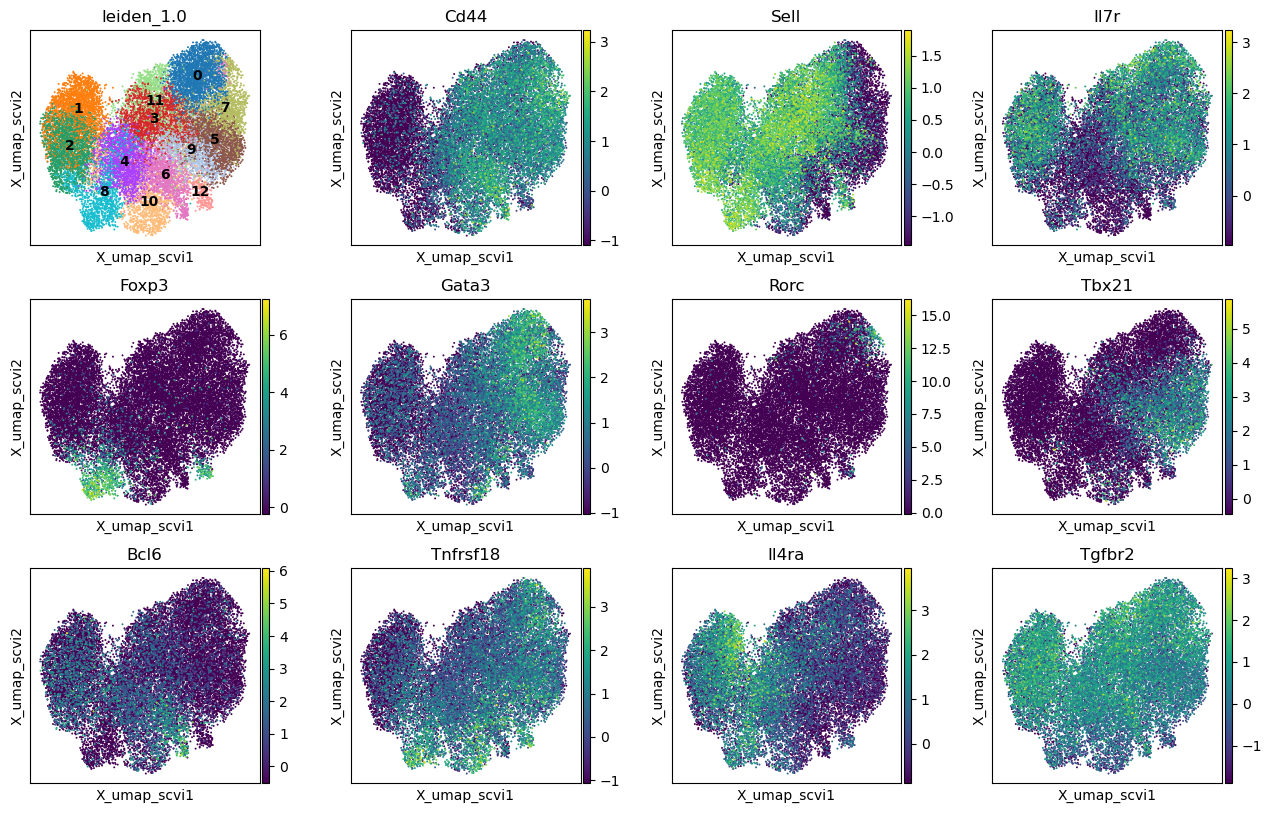

In [ ]:
sc.pl.embedding(rna, color=['leiden_1.0','Cd44','Sell','Il7r','Foxp3','Gata3','Rorc','Tbx21','Bcl6','Tnfrsf18','Il4ra','Tgfbr2'],
                basis='X_umap_scvi', legend_loc='on data', size=8)

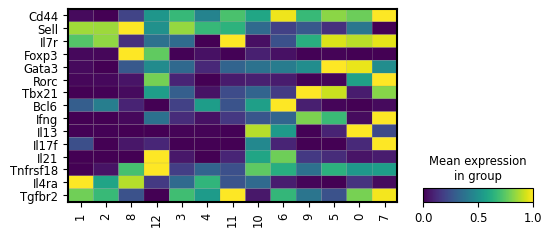

In [ ]:
plot_genes = ['Cd44','Sell','Il7r','Foxp3','Gata3','Rorc','Tbx21','Bcl6','Ifng','Il13','Il17f','Il21','Tnfrsf18','Il4ra','Tgfbr2']

order = ['1','2','8','12','3','4','11','10','6','9','5','0','7']
g = sc.pl.matrixplot(rna, var_names=plot_genes,
                     groupby='leiden_1.0', standard_scale='var', dendrogram=False, swap_axes=True, cmap='viridis',
                     categories_order=order,
                     return_fig=True, figsize=(6,2.5))

ranking genes


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


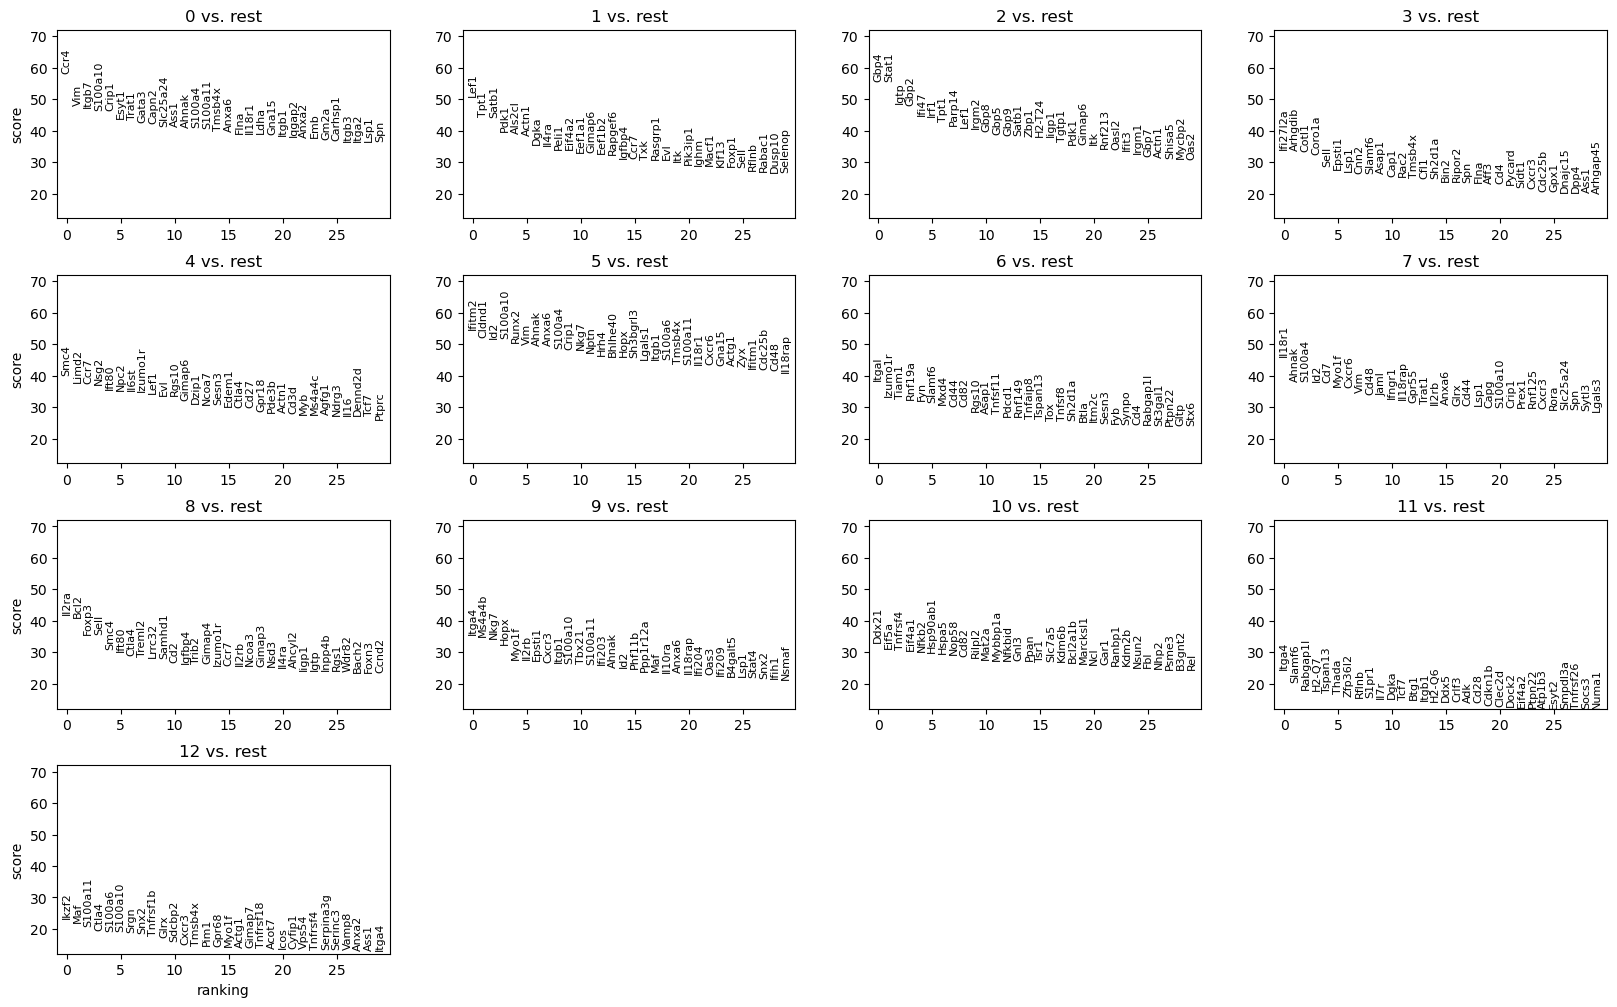

In [ ]:
sc.tl.rank_genes_groups(rna, groupby='leiden_1.0', layer='log1p_norm', method='wilcoxon', pts=True)
sc.pl.rank_genes_groups(rna, n_genes=30)
wilcoxon_df = sc.get.rank_genes_groups_df(rna, group=None)
#wilcoxon_df.to_csv('/data1/rudenska/EYW/git_projects/SIG19/analysis_outs/leiden1.0_wilcoxon_markers_DTR_iLN.csv')

# Milo Analysis

## Milo Processing

Here, we perform the Milo processing steps including calculating neighbors and creating neighborhoods. We will calculate the nearest neighbors graph using the scVI latent space, which is adjusted for covariates (cage, percent mitochondrial, S score, G2M score)

In [23]:
# prepare metadata
rna.obs['treatment'] = rna.obs['treatment'].astype(str).str.replace("-|\\.", "", regex=True)
rna.obs['treatment'] = rna.obs['treatment'].astype('category').cat.reorder_categories([
        "isotype",
        "DTA1",
        "GK15IL4",
        "GK15BGo",
        "DTA1BGo",
        "DTA1IL4"
])
rna.obs["cage"] = rna.obs["cage"].astype(str).astype('category')   

In [24]:
# calculate neighbors using the scVI latent space
sc.pp.neighbors(rna, use_rep='X_scvi', n_neighbors=1000)
# make milo mdata and only include hvg in rna
milo = pt.tl.Milo()
mdata = milo.load(rna[:,rna.var['highly_variable']].copy())
# make milo nhoods and count by biological replicate (mouse)
milo.make_nhoods(mdata, prop=0.05)
mdata = milo.count_nhoods(mdata, sample_col="mouse")

computing neighbors


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:03:13)


Text(0, 0.5, '# neighbouthoods')

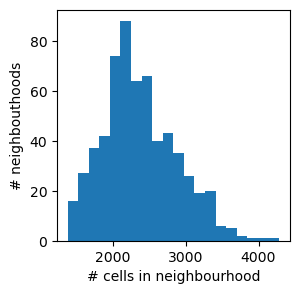

In [25]:
# plot the size of milo neighborhoods
nhood_size = mdata['rna'].obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

## Differential Abundance Tests

Perform DA tests using milo with different contrasts (one mdata per contrast). At this stage the tests are performed at "pseudobulk" level (e.g. between biological replicates) so we will adjust for cage as a covariate.

In [26]:
mdata_DTA1 = mdata.copy()
mdata_BGo = mdata.copy()
mdata_IL4 = mdata.copy()
mdata_DTA1BGo = mdata.copy()
mdata_DTA1IL4 = mdata.copy()
mdata_DTA1BGo_synergy = mdata.copy()
mdata_DTA1IL4_synergy = mdata.copy()

In [27]:
# perform DA tests, each test a separate mdata object
milo.da_nhoods(mdata_DTA1, design="~cage+treatment",
               model_contrasts='treatmentDTA1', solver='edger')
milo.da_nhoods(mdata_BGo, design="~cage+treatment",
               model_contrasts='treatmentGK15BGo', solver='edger')
milo.da_nhoods(mdata_IL4, design="~cage+treatment",
               model_contrasts='treatmentGK15IL4', solver='edger')
milo.da_nhoods(mdata_DTA1BGo, design="~cage+treatment",
               model_contrasts='treatmentDTA1BGo', solver='edger')
milo.da_nhoods(mdata_DTA1IL4, design="~cage+treatment",
               model_contrasts='treatmentDTA1IL4', solver='edger')
milo.da_nhoods(mdata_DTA1BGo_synergy, design="~cage+treatment",
               model_contrasts='treatmentDTA1BGo-treatmentDTA1-treatmentGK15BGo', solver='edger')
milo.da_nhoods(mdata_DTA1IL4_synergy, design="~cage+treatment",
               model_contrasts='treatmentDTA1IL4-treatmentDTA1-treatmentGK15IL4', solver='edger')

# collect mdata objects in a list
mdata_list = [mdata_DTA1, mdata_BGo, mdata_IL4, mdata_DTA1BGo, mdata_DTA1IL4,
              mdata_DTA1BGo_synergy, mdata_DTA1IL4_synergy]

In [28]:
# annotate neighborhoods with leiden clusters
for m in mdata_list:
    milo.build_nhood_graph(m, basis="X_umap_scvi")
    milo.annotate_nhoods(m, anno_col="leiden_1.0")

## Visualize DA Results

### Define Custom Function

In [29]:
# define custom plot nhood function for ~aesthetics~ and to enable custom vmin vmax setups
from mudata import MuData
from matplotlib.axes import Axes
from matplotlib.colors import Colormap
from matplotlib.figure import Figure
from collections.abc import Sequence
def plot_nhood_graph_custom(
        mdata: MuData,
        *,
        vmin: float = -1.0,
        vmax: float = 1.0,
        alpha: float = 0.1,
        min_logFC: float = 0,
        min_size: int = 10,
        plot_edges: bool = False,
        title: str = "DA log-Fold Change",
        color_map: Colormap | str | None = None,
        palette: str | Sequence[str] | None = None,
        ax: Axes | None = None,
        return_fig: bool = False,
        **kwargs,
    ) -> Figure | None:
        """Visualize DA results on abstracted graph (wrapper around sc.pl.embedding).

        Args:
            mdata: MuData object
            alpha: Significance threshold. (default: 0.1)
            min_logFC: Minimum absolute log-Fold Change to show results. If is 0, show all significant neighbourhoods.
            min_size: Minimum size of nodes in visualization. (default: 10)
            plot_edges: If edges for neighbourhood overlaps whould be plotted.
            title: Plot title.
            {common_plot_args}
            **kwargs: Additional arguments to `scanpy.pl.embedding`.

        Examples:
            >>> import pertpy as pt
            >>> import scanpy as sc
            >>> adata = pt.dt.bhattacherjee()
            >>> milo = pt.tl.Milo()
            >>> mdata = milo.load(adata)
            >>> sc.pp.neighbors(mdata["rna"])
            >>> sc.tl.umap(mdata["rna"])
            >>> milo.make_nhoods(mdata["rna"])
            >>> mdata = milo.count_nhoods(mdata, sample_col="orig.ident")
            >>> milo.da_nhoods(mdata,
            >>>            design='~label',
            >>>            model_contrasts='labelwithdraw_15d_Cocaine-labelwithdraw_48h_Cocaine')
            >>> milo.build_nhood_graph(mdata)
            >>> milo.plot_nhood_graph(mdata)

        Preview:
            .. image:: /_static/docstring_previews/milo_nhood_graph.png
        """
        nhood_adata = mdata["milo"].T.copy()
        nhood_adata.obs = nhood_adata.obs.drop(columns=['adjust.method', 'comparison', 'test'])

        nhood_adata.obs["graph_color"] = nhood_adata.obs["logFC"]
        nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan
        nhood_adata.obs["abs_logFC"] = abs(nhood_adata.obs["logFC"])
        nhood_adata.obs.loc[nhood_adata.obs["abs_logFC"] < min_logFC, "graph_color"] = np.nan

        # Plotting order - extreme logFC on top
        nhood_adata.obs.loc[nhood_adata.obs["graph_color"].isna(), "abs_logFC"] = np.nan
        ordered = nhood_adata.obs.sort_values("abs_logFC", na_position="first").index
        nhood_adata = nhood_adata[ordered]

        fig = sc.pl.embedding(
            nhood_adata,
            "X_milo_graph",
            color="graph_color",
            cmap="RdBu_r",
            size=nhood_adata.obs["Nhood_size"] * min_size,
            edges=plot_edges,
            neighbors_key="nhood",
            sort_order=False,
            frameon=True,
            vmax=vmax,
            vmin=vmin,
            title=title,
            color_map=color_map,
            palette=palette,
            ax=ax,
            show=False,
            **kwargs,
        )

        if return_fig:
            return fig
        plt.show()
        return None

In [ ]:
# modified to enable changing dot size and to hide clusters that do not contain
# any annotated nhoods
def plot_da_beeswarm_custom(
    mdata: MuData,
    *,
    feature_key: str | None = "rna",
    anno_col: str = "nhood_annotation",
    alpha: float = 0.1,
    palette: str | Sequence[str] | dict[str, str] | None = None,
    dot_size: float = 2.0,  # Added parameter
    return_fig: bool = False,
) -> Figure | None:
    """Plot beeswarm plot of logFC against nhood labels."""
    # 1. Create and filter the DataFrame first
    nhood_adata = mdata["milo"].T.copy()
    anno_df = nhood_adata.obs[[anno_col, "logFC", "SpatialFDR"]].copy()
    anno_df["is_signif"] = anno_df["SpatialFDR"] < alpha
    anno_df = anno_df[anno_df[anno_col] != "nan"]
    
    # Remove unused categories to prevent empty rows if categorical
    if hasattr(anno_df[anno_col], "cat"):
         anno_df[anno_col] = anno_df[anno_col].cat.remove_unused_categories()

    # 2. Calculate sorted order based only on the filtered data
    sorted_annos = (
        anno_df[[anno_col, "logFC"]]
        .groupby(anno_col, observed=True) # observed=True prevents plotting empty categories
        .median()
        .sort_values("logFC", ascending=True)
        .index
    )

    obs_col = nhood_adata.uns["annotation_obs"]
    if palette is None:
        palette = dict(
            zip(
                mdata[feature_key].obs[obs_col].cat.categories,
                mdata[feature_key].uns[f"{obs_col}_colors"],
                strict=False,
            )
        )
    sns.violinplot(
        data=anno_df,
        y=anno_col,
        x="logFC",
        order=sorted_annos,
        inner=None,
        orient="h",
        hue=anno_col,
        palette=palette,
        legend=False,
        linewidth=0,
        density_norm='width',
    )
        
    sns.stripplot(
        data=anno_df,
        y=anno_col,
        x="logFC",
        order=sorted_annos,
        size=dot_size, # Use new dot_size parameter
        hue="is_signif",
        palette={False: "grey", True: "red"}, # Explicit map: Not Significant=Grey, Significant=Red
        orient="h",
        alpha=1.0,
    )
    
    plt.legend(loc="upper left", title=f"< {int(alpha * 100)}% SpatialFDR", bbox_to_anchor=(1, 1), frameon=False)
    plt.axvline(x=0, ymin=0, ymax=1, color="black", linestyle="--")

    if return_fig:
        return plt.gcf()
    plt.show()
    return None

In [86]:
def plot_cluster_lfc_across_treatments(
    mdata_list: list[MuData],
    labels: list[str],
    cluster_name: str,
    *,
    feature_key: str = "rna",
    anno_col: str = "nhood_annotation",
    alpha: float = 0.1,
    dot_size: float = 2.0,
    ylim: tuple[float, float] | None = None, # Added parameter
    ax: plt.Axes | None = None,
    return_fig: bool = False,
):
    if len(mdata_list) != len(labels):
        raise ValueError("Length of mdata_list must match length of labels")

    # 1. Extract color
    cluster_color = "lightgrey"
    try:
        ref_mdata = mdata_list[0]
        obs_col = ref_mdata["milo"].T.uns["annotation_obs"]
        color_map = dict(zip(
            ref_mdata[feature_key].obs[obs_col].cat.categories,
            ref_mdata[feature_key].uns[f"{obs_col}_colors"],
            strict=False
        ))
        cluster_color = color_map.get(str(cluster_name), "lightgrey")
    except Exception:
        pass

    # 2. Collect Data
    data_list = []
    for mdata, label in zip(mdata_list, labels):
        try:
            obs = mdata["milo"].T.obs
            subset = obs[obs[anno_col] == cluster_name].copy()
            if not subset.empty:
                subset["Treatment"] = label
                subset["is_signif"] = subset["SpatialFDR"] < alpha
                data_list.append(subset[["logFC", "Treatment", "is_signif"]])
        except KeyError:
            continue

    if not data_list:
        print(f"No data for {cluster_name}")
        return None

    plot_df = pd.concat(data_list)
    plot_df["Treatment"] = pd.Categorical(plot_df["Treatment"], categories=labels, ordered=True)

    # 3. Plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(len(labels) * 0.8, 5))
    
    sns.violinplot(
        data=plot_df, x="Treatment", y="logFC", ax=ax,
        inner=None, linewidth=0, color=cluster_color, cut=0, density_norm='width'
    )
    sns.stripplot(
        data=plot_df, x="Treatment", y="logFC", ax=ax,
        size=dot_size, hue="is_signif", palette={False: "grey", True: "red"},
        jitter=True, dodge=False, alpha=1.0, legend=False
    )

    ax.axhline(0, linestyle="--", color="black", linewidth=1)
    ax.set_title(f"Cluster: {cluster_name}")
    ax.tick_params(axis='x', rotation=90) 

    # Apply y-axis limit if specified
    if ylim is not None:
        ax.set_ylim(ylim)
    
    if return_fig:
        return ax.get_figure()

### Plot DA Graphs

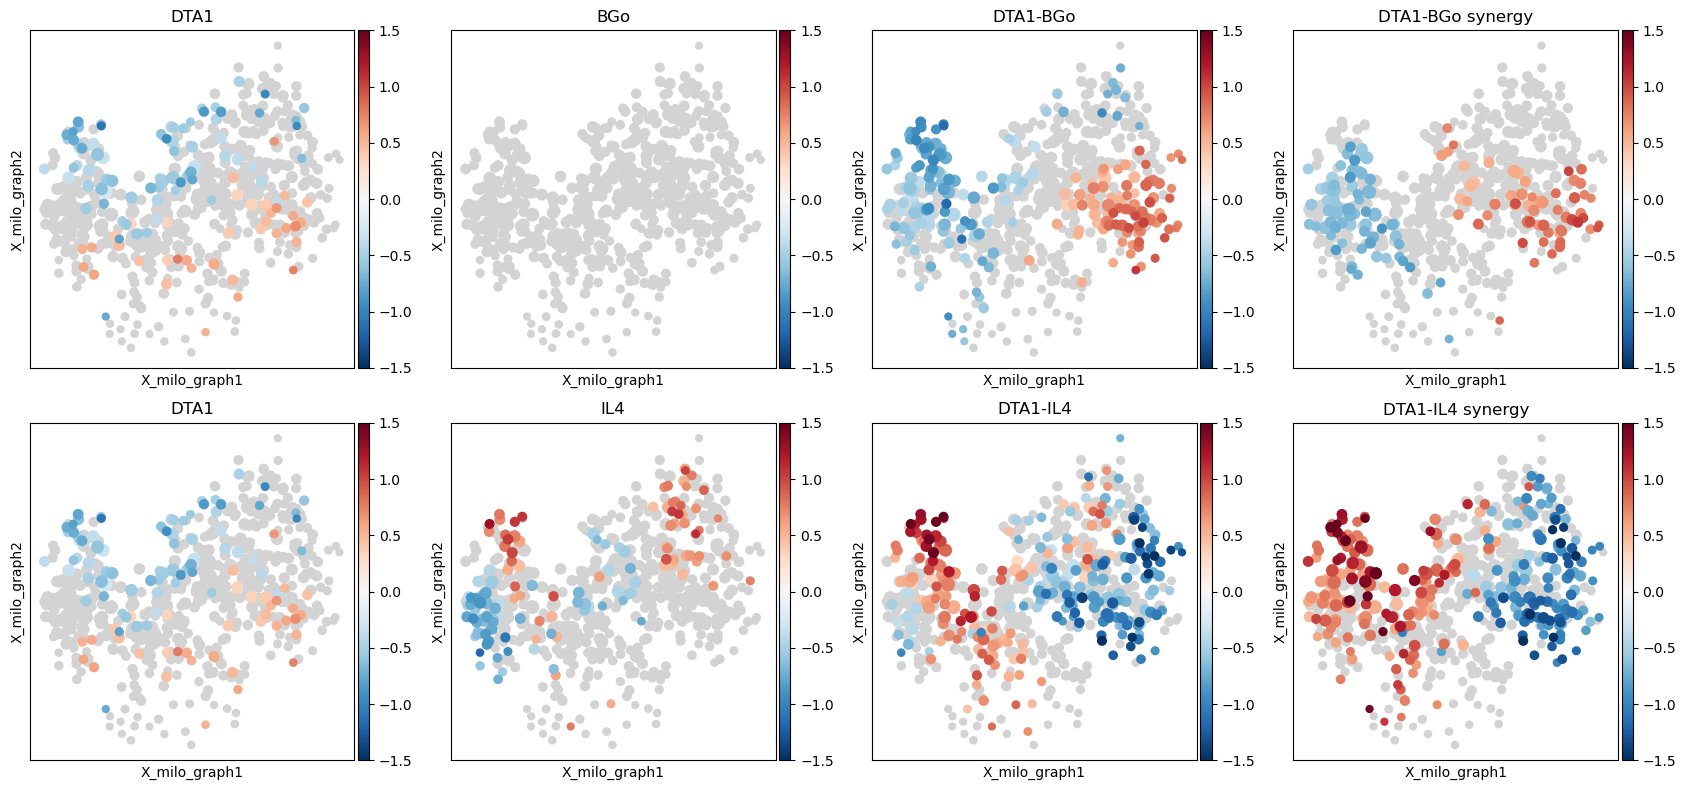

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(17, 8))
axes = axes.flatten()

mdata_plot = [mdata_DTA1, mdata_BGo, mdata_DTA1BGo, mdata_DTA1BGo_synergy,
              mdata_DTA1, mdata_IL4, mdata_DTA1IL4, mdata_DTA1IL4_synergy]
treatment_names = ['DTA1', 'BGo', 'DTA1-BGo', 'DTA1-BGo synergy',
                   'DTA1', 'IL4', 'DTA1-IL4', 'DTA1-IL4 synergy']

for i, m in enumerate(mdata_plot):
    plot_nhood_graph_custom(
        mdata = m,
        alpha=0.1,
        min_size=0.1,
        return_fig=True,
        vmin=-1.5,
        vmax=1.5,
        ax=axes[i]
    )
    axes[i].set_title(treatment_names[i])

plt.tight_layout()
#fig.savefig('/data1/rudenska/EYW/git_projects/SIG19/analysis_outs/plots/SIG19_DTR_iLN_DA_nhoods.pdf', bbox_inches='tight')
plt.show()

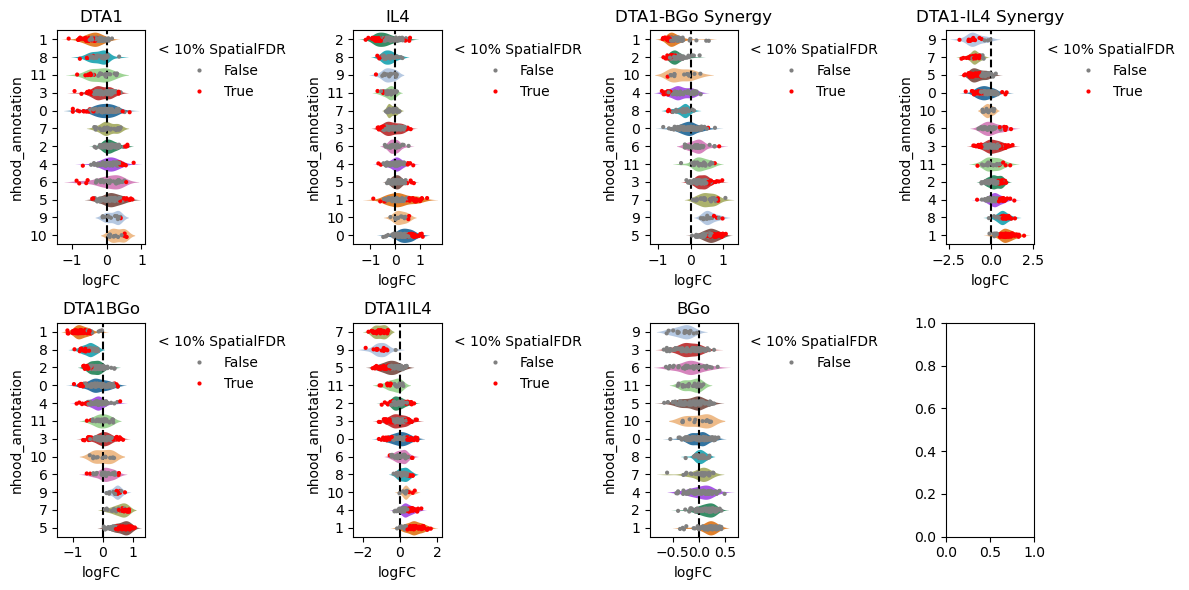

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

plt.sca(axes[0, 0])
plot_da_beeswarm_custom(mdata_DTA1, alpha=0.1, dot_size=3, return_fig=True)
axes[0, 0].set_title('DTA1')

plt.sca(axes[0, 1])
plot_da_beeswarm_custom(mdata_IL4, alpha=0.1, dot_size=3, return_fig=True)
axes[0, 1].set_title('IL4')

plt.sca(axes[0, 2])
plot_da_beeswarm_custom(mdata_DTA1BGo_synergy, alpha=0.1, dot_size=3, return_fig=True)
axes[0, 2].set_title('DTA1-BGo Synergy')

plt.sca(axes[0, 3])
plot_da_beeswarm_custom(mdata_DTA1IL4_synergy, alpha=0.1, dot_size=3, return_fig=True)
axes[0, 3].set_title('DTA1-IL4 Synergy')

plt.sca(axes[1, 0])
plot_da_beeswarm_custom(mdata_DTA1BGo, alpha=0.1, dot_size=3, return_fig=True)
axes[1, 0].set_title('DTA1BGo')

plt.sca(axes[1, 1])
plot_da_beeswarm_custom(mdata_DTA1IL4, alpha=0.1, dot_size=3, return_fig=True)
axes[1, 1].set_title('DTA1IL4')

plt.sca(axes[1, 2])
plot_da_beeswarm_custom(mdata_BGo, alpha=0.1, dot_size=3, return_fig=True)
axes[1, 2].set_title('BGo')

plt.tight_layout()
#fig.savefig('/data1/rudenska/EYW/git_projects/SIG19/analysis_outs/plots/SIG19_DTR_iLN_DA_beeswarm_combined.pdf', bbox_inches='tight')

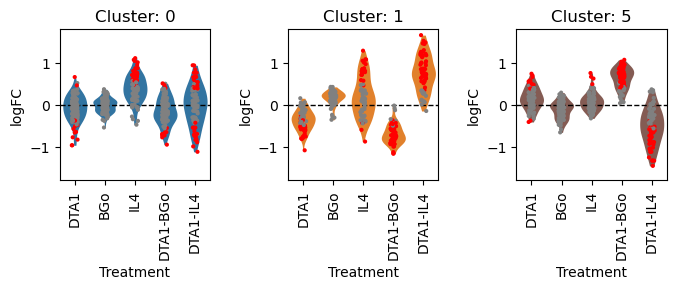

In [ ]:
# Define data once
mdatas = [mdata_DTA1, mdata_BGo, mdata_IL4, mdata_DTA1BGo, mdata_DTA1IL4]
labels = ['DTA1', 'BGo', 'IL4', 'DTA1-BGo', 'DTA1-IL4']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(7, 3))

# Plot on specific axes
plot_cluster_lfc_across_treatments(mdatas, labels, cluster_name='0', ax=axes[0], dot_size=3, ylim=(-1.8,1.8))
plot_cluster_lfc_across_treatments(mdatas, labels, cluster_name='1', ax=axes[1], dot_size=3, ylim=(-1.8,1.8))
plot_cluster_lfc_across_treatments(mdatas, labels, cluster_name='5', ax=axes[2], dot_size=3, ylim=(-1.8,1.8))

plt.tight_layout()
plt.show()
#fig.savefig('/data1/rudenska/EYW/git_projects/SIG19/analysis_outs/plots/SIG19_DTR_iLN_DA_individual_clusters.pdf', bbox_inches='tight')

# sPCA Component Module Scoring

Here, we will score cells in the dataset for different sPCA components derived from single and combinatorial stimulations of bulk RNA-seq of differentiated CD4 T cells.

In [3]:
# import data
rna = sc.read_h5ad('/data1/rudenska/EYW/SIG19/scvi_outs/SIG19_DTR_CD4T_iLN_scvi.h5ad')

In [4]:
# transform input data
rna_list = [rna]
for rna_sub in rna_list:
    # preprocess data
    rna_sub.X = rna_sub.layers['counts'].copy()
    sc.pp.normalize_total(rna_sub)
    sc.pp.log1p(rna_sub)
    rna_sub.layers['log1p_norm'] = rna_sub.X.copy()
    sc.pp.scale(rna_sub)
    rna_sub.layers['log1p_norm_scaled'] = rna_sub.X.copy()

normalizing counts per cell
    finished (0:00:00)


/home/wange7/miniforge3/envs/scanpy_standard2/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [5]:
# Load sPCA features
features = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG18/analysis_outs/spca/zscore_degs/zscore_degs_unscaled_alpha10.0_sPCA_components.csv")
spca_lm = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG18/analysis_outs/spca/lm_fit_zscore_degs_alpha10.0_sPCA_clean.csv")

# pull out clean spca components
clean_comps = spca_lm['component'].unique().tolist()
clean_comps = [c.replace("comp_", "") for c in clean_comps]

# Create a dictionary to store top 50 gene names for each component based on value
comp_genes = {}
for comp in clean_comps:
    comp_values = features[[comp, 'gene']].copy()
    top_genes = comp_values.sort_values(comp, ascending=False).head(50)['gene'].tolist()
    comp_genes[f'comp_{comp}'] = top_genes

In [6]:
for rna_sub in rna_list:
    # Score each component with scaled data
    for comp_name, gene_list in comp_genes.items():
        sc.tl.score_genes(rna_sub,
                        gene_list=gene_list,
                        score_name=f'SIG18_score_scaled_{comp_name}',
                        ctrl_size=100,
                        layer='log1p_norm_scaled'
                        )

computing score 'SIG18_score_scaled_comp_0'


    finished: added
    'SIG18_score_scaled_comp_0', score of gene set (adata.obs).
    2291 total control genes are used. (0:00:01)
computing score 'SIG18_score_scaled_comp_1'
       '1700025G04Rik', 'Sema3b', 'Gnal', 'Gm15518'],
      dtype='object')
    finished: added
    'SIG18_score_scaled_comp_1', score of gene set (adata.obs).
    1991 total control genes are used. (0:00:01)
computing score 'SIG18_score_scaled_comp_10'
       'Gm30054', 'E430014B02Rik'],
      dtype='object')
    finished: added
    'SIG18_score_scaled_comp_10', score of gene set (adata.obs).
    1989 total control genes are used. (0:00:01)
computing score 'SIG18_score_scaled_comp_11'
       'Gm15518', 'Dennd11', 'Gm43822', '1810041H14Rik', 'Ly6c2', 'Qars1'],
      dtype='object')
    finished: added
    'SIG18_score_scaled_comp_11', score of gene set (adata.obs).
    1590 total control genes are used. (0:00:01)
computing score 'SIG18_score_scaled_comp_12'
       'H2-T-ps', 'Lppos'],
      dtype='object')
    f

In [7]:
# export scores
rna.obs.to_csv('/data1/rudenska/EYW/git_projects/SIG19/analysis_outs/projection/DTR_CD4T_iLN_scored_obs.csv')